# Timing correction and speed control

Conductance-based LIF network:

$$C_m^i \frac{dv^i}{dt} = g_l[E_l^i - V^i(t)] + g^i_e(t)[E_e - V^i(t)] + g^i_i(t)[E_i - V^i(t)] + I^i_{ext}(t)$$

The time-varying conductances $g^i_e$ and $g^i_i$ are exponentially filtered sums of spike trains from upstream neurons $j$, with time constants $\tau_e$ and $\tau_i$ and weighted by $W_e^{ij}$ and $W_i^{ij}$ respectively.

All param values are in SI units, with capacitance and conductance per cm$^2$.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## BASE MODEL
M = {
    # E membrane
    'C_M_E': 1e-6, 'G_L_E': .1e-3,  # T_M (s) = C_M (F/cm^2) / G_L (S/cm^2)
    'E_L_E': -0.06, 'V_TH_E': -0.05, 'V_R_E': -0.06, 'T_R_E': 0.002,
    
    # I membrane
    'C_M_I': 1e-6, 'G_L_I': .2e-3,  # T_M = C_M_/G_L
    'E_L_I': -0.06, 'V_TH_I': -0.05, 'V_R_I': -0.06, 'T_R_I': 0.002,
    
    # syn rev potentials & time constants
    'E_E': 0, 'E_I': -0.08, 'T_E': 0.002, 'T_I': 0.002,
    
    # architecture
    'N_L': 200,  # num links
    'N_L_E': 30,  # num E nrns in chain link
    'W_E_E_R': 0.005e-3,  # E->E recurrent cxns w/in link
    'W_E_E_F': 0.01e-3,  # E->E feed-forward cxns btwn links
    'T_R_E': 1,  # extra long refrac period (s)
    'SGM_N': .5e-9,  # A*sqrt(s)
    
    # modulatory control
    'V_F': 1.2, 'W': 0.4, 'H': 0.4, 'T_P_CH': 0.04,
    'FQ_SPK_U_I': 800,  # inh input freq while modulation is on
    'W_U_E_I': 0.05e-3,  
    
}

## SMLN
S = {
    'RNG_SEED': 0, 'DT': .0005, 'T': 0.25,
}

print('T_M_E =', 1000*M['C_M_E']/M['G_L_E'], 'ms')
print('T_M_I =', 1000*M['C_M_I']/M['G_L_I'], 'ms')

T_M_E = 10.0 ms
T_M_I = 5.0 ms


# Spatiotemporally modulated spike sequence

In [2]:
# set up modulatory signal

def to_ch_units(v_f_ch, v_s_ch, v_f, w, h, t_p_ch):
    """Convert unitless params to units of chain links and seconds.
    
    :param v_f_ch: fast chain speed (links/sec)
    :param v_s_ch: slow chian speed (links/sec)
    :param v_f: fast speed (unitless)
    :param w: temporal czone width (btwn 0 and 1)
    :param h: spatial czone width (btwn 0 and 1)
    :param t_p_ch: temporal chain period (sec)
    
    """
    v_ch = v_f_ch / v_f  # stable speed in chain links / sec
    x_p_ch = v_ch * t_p_ch  # spatial period in chain links
    w_ch = t_p_ch * w
    h_ch = x_p_ch * h
    
    v_s = v_f * (v_s_ch/v_f_ch)
    
    print('v_ch = {0:.3f} links/s'.format(v_ch))
    print('x_p_ch = {0:.3f} links'.format(x_p_ch))
    print('t_p_ch = {0:.3f} s'.format(t_p_ch))
    print('w_ch = {0:.3f} s'.format(w_ch))
    print('h_ch = {0:.3f} links'.format(h_ch))
    
    return Generic(
        v_f=v_f, v_s=v_s, w=w, h=h,
        v_f_ch=v_f_ch, v_s_ch=v_s_ch, v_ch=v_ch, x_p_ch=x_p_ch, t_p_ch=t_p_ch, w_ch=w_ch, h_ch=h_ch)

def plot_czone(ctl_prm, figsize=(12, 10)):
    
    t = np.arange(0, S['T'], S['DT'])
    x = np.arange(0, M['N_L'], .01)

    a = .5 * (signal.square((2*np.pi/ctl_prm.t_p_ch)*t, ctl_prm.w) + 1)
    b = .5 * (signal.square((2*np.pi/ctl_prm.x_p_ch)*x, ctl_prm.h) + 1)

    gs = gridspec.GridSpec(6, 6)
    fig = plt.figure(figsize=figsize, tight_layout=True)
    axs = [fig.add_subplot(gs[0, :-1]), fig.add_subplot(gs[1:, -1]), fig.add_subplot(gs[1:, :-1])]

    axs[0].plot(t, a, c='b', lw=2)
    axs[0].fill_between(t, np.zeros(len(a)), a, color='b', alpha=.3)
    axs[0].set_xlim(0, S['T'])
    axs[0].set_ylim(-.1, 1.1)

    axs[0].set_xticks([])
    axs[0].set_yticks([0, 1])
    axs[0].set_xlabel('Temporal modulation: a(t)', color='b')
    axs[0].xaxis.set_label_position('top') 

    axs[1].plot(b, x, c='r', lw=2)
    axs[1].fill_betweenx(x, np.zeros(len(x)), b, color='r', alpha=.3)
    axs[1].set_ylim(0, M['N_L'])
    axs[1].set_xlim(-.1, 1.1)

    axs[1].set_yticks([])
    axs[1].set_xticks([0, 1])
    axs[1].set_ylabel('Spatial modulation: b(x)', color='r')
    axs[1].yaxis.set_label_position('right')

    for t_ in np.arange(0, S['T'], ctl_prm.t_p_ch):
        for x_ in np.arange(0, M['N_L'], ctl_prm.x_p_ch):
            axs[2].fill_between(
                [t_, t_+ctl_prm.w_ch], [x_]*2, [x_+ctl_prm.h_ch]*2,
                color='violet', alpha=.3, zorder=0)

    axs[2].set_xlim(0, S['T'])
    axs[2].set_ylim(0, M['N_L'])
    axs[2].set_xlabel('t (s)')
    axs[2].set_ylabel('x (link)')

    for ax in axs:
        set_font_size(ax, 16)
        
    return axs

## Correction zone setup

v_ch = 970.833 links/s
x_p_ch = 38.833 links
t_p_ch = 0.040 s
w_ch = 0.016 s
h_ch = 15.533 links


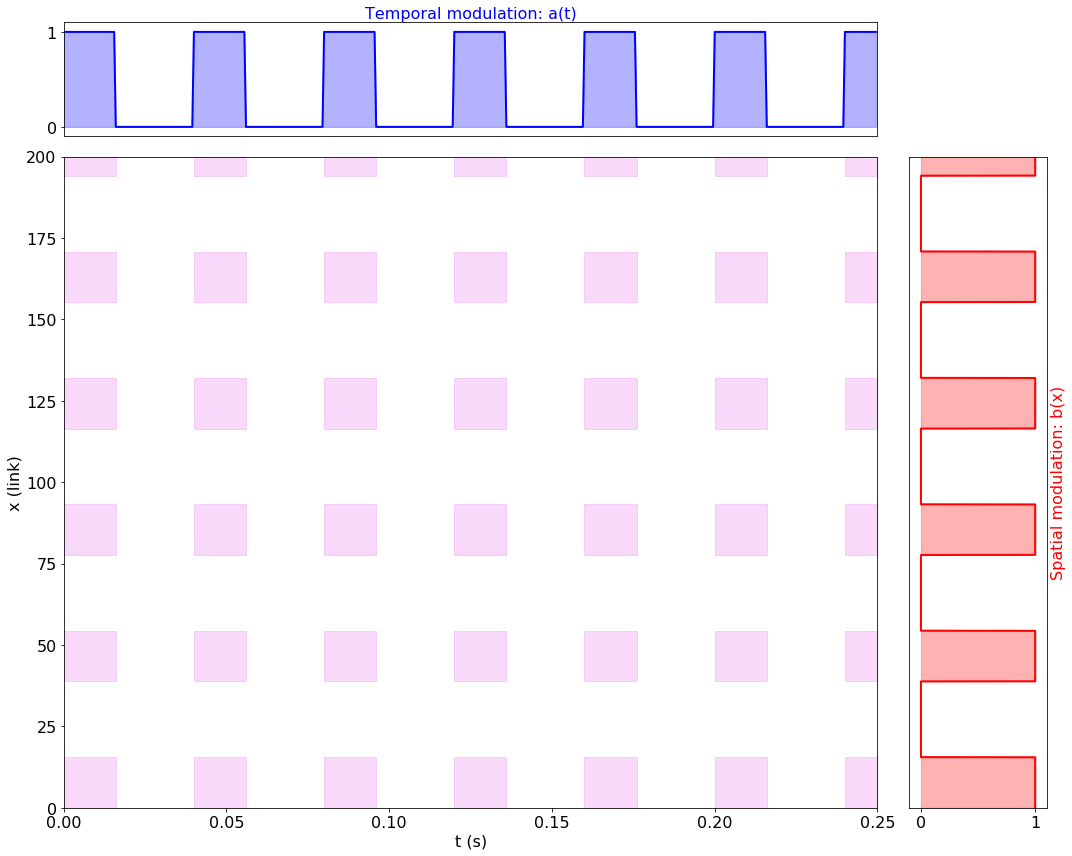

In [3]:
ctl_prm = to_ch_units(v_f_ch=1165, v_s_ch=570, v_f=M['V_F'], w=M['W'], h=M['H'], t_p_ch=M['T_P_CH'])
plot_czone(ctl_prm, figsize=(15, 12));

# Simulation setup

In [4]:
m = copy(M)
m['N_E'] = m['N_L']*m['N_L_E']

## Temporal modulation setup
This is given by a population-averaged but time-varying mean inhibitory input rate.

In [5]:
t = np.arange(0, S['T'], S['DT'])
a = .5 * (signal.square((2*np.pi/ctl_prm.t_p_ch)*t, ctl_prm.w) + 1)

spks_u_inh = np.zeros((len(t), m['N_L_E'] + m['N_E']), dtype=int)
spks_u_inh[:, m['N_L_E']:] = np.random.poisson(np.array(a * m['FQ_SPK_U_I'] * S['DT'])[:, None], (len(t), m['N_E']))

## Spatial modulation setup

In [6]:
x_b = np.arange(m['N_L'])
b = .5 * (signal.square((2*np.pi/ctl_prm.x_p_ch)*x_b, ctl_prm.h) + 1)

## positional labels
x = np.tile(x_b[:, None], (1, m['N_L_E'])).flatten()

## x-modulated inp weight
w_u_e_i_diag = m['W_U_E_I'] * np.tile(b[:, None], (1, m['N_L_E'])).flatten()

## Trigger input

In [7]:
# trigger inputs
t_trg = .02
d_trg = .002

t_mask = (t_trg <= t) & (t < (t_trg + d_trg))
tmp = cc([np.ones(m['N_L_E'], int), np.zeros(m['N_L_E']*(t_mask.sum()-1))])

spks_u_trg = np.zeros((len(t), m['N_L_E'] + m['N_E']), dtype=int)
spks_u_trg[t_mask, :m['N_L_E']] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m['N_L_E'])

## External noise

In [8]:
i_ext = m['SGM_N']/S['DT'] * np.random.randn(len(t), m['N_E'])

## Network and baseline inputs setup

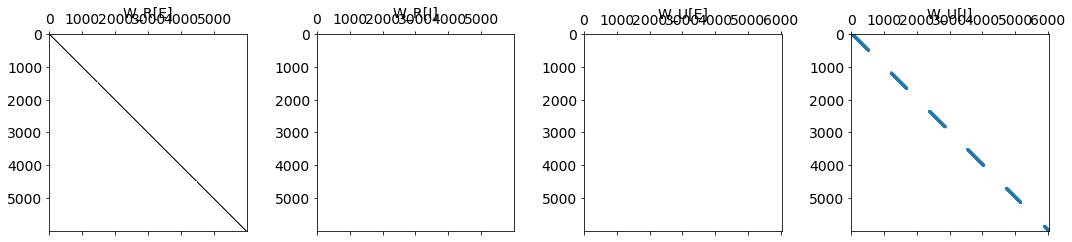

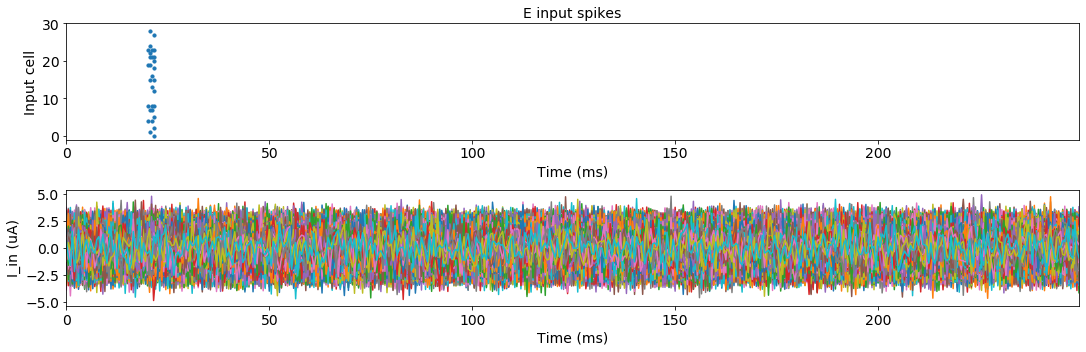

In [9]:
# set up ntwk
## E-E weights
w_r_e_e = \
    m['W_E_E_R'] * np.kron(np.eye(m['N_L'], k=0), np.ones([m['N_L_E']]*2)) + \
    m['W_E_E_F'] * np.kron(np.eye(m['N_L'], k=-1), np.ones([m['N_L_E']]*2))  # btwn links

w_r = {
    'E': w_r_e_e,
    'I': np.zeros((m['N_E'], m['N_E'])),
}

## input weights
w_u = {
    'E': np.block([
        [ m['W_E_E_F']*np.ones([m['N_L_E']]*2), np.zeros([m['N_L_E'], m['N_E']]) ],
        [ np.zeros([m['N_E']-m['N_L_E'],m['N_L_E']*(m['N_L']+1)]) ],
    ]),
    
    'I': np.block([
        [np.zeros([m['N_E'], m['N_L_E']]), np.diag(w_u_e_i_diag)],
    ])
}

ntwk = LIFNtwkG(
    c_m=m['C_M_E'],
    g_l=m['G_L_E'],
    e_l=m['E_L_E'],
    v_th=m['V_TH_E'],
    v_r=m['V_R_E'],
    t_r=m['T_R_E'],
    e_s={'E': m['E_E'], 'I': m['E_I']},
    t_s={'E': m['T_E'], 'I': m['T_E']},
    w_r=w_r,
    w_u=w_u)

ntwk.x = x.copy()

# helpful plots
fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)
axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[0].set_title('W_R[E]')
axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
axs[1].set_title('W_R[I]')

axs[2].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
axs[2].set_title('W_U[E]')
axs[3].spy(w_u['I'], markersize=1)
axs[3].set_title('W_U[I]')

for ax in axs.flatten():
    set_font_size(ax, 14)

fig, axs = plt.subplots(2, 1, figsize=(15, 5), tight_layout=True)
t_spk_u_e, c_spk_u_e = np.nonzero(spks_u_trg[:, :m['N_L_E']])
t_spk_u_e = t_spk_u_e * S['DT']

# input spikes
axs[0].scatter(1000*t_spk_u_e, c_spk_u_e, s=10)
axs[0].set_ylim(-1, m['N_L_E'])
axs[0].set_title('E input spikes')
axs[0].set_ylabel('Input cell')

# input current
axs[1].plot(1000*t, 1e6*i_ext)
axs[1].set_ylabel('I_in (uA)')

for ax in axs:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    set_font_size(ax, 14)

## Simulation

In [10]:
spks_u = spks_u_trg + spks_u_inh
clamp = Generic(v={0: np.repeat(m['E_L_E'], m['N_E'])}, spk={})

rsp = ntwk.run(dt=S['DT'], clamp=clamp, i_ext=i_ext, spks_u=spks_u)

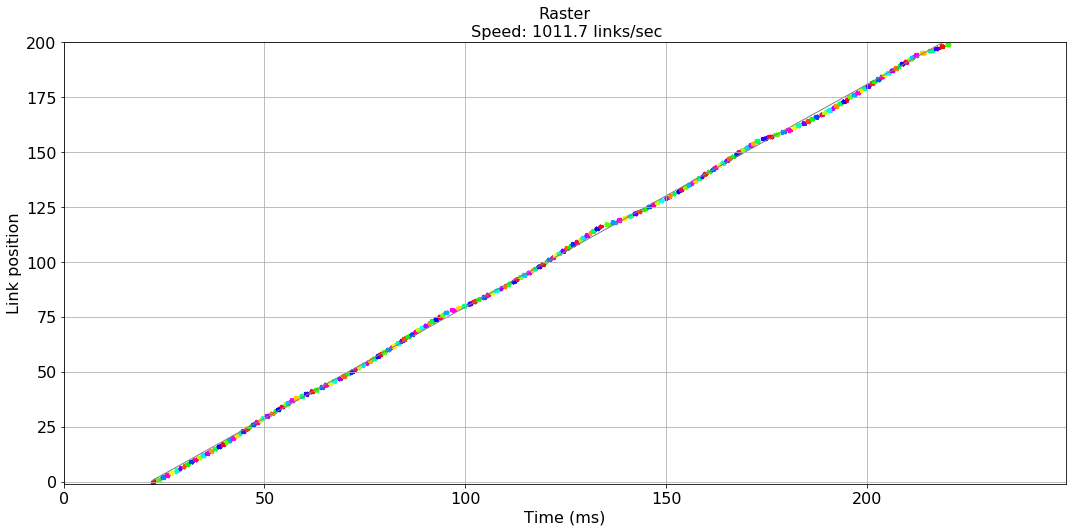

In [11]:
# plot results (spks and voltage for each chain link)
c = get_spaced_colors('hsv', m['N_L'], 75/256)
v_space = 1.5 * (m['V_TH_E'] - m['E_I'])

fig, ax = plt.subplots(1, 1, figsize=(15, 7.5), tight_layout=True)
axs = [ax]

t_spk_all = []
x_spk_all = []

for l_ctr in range(m['N_L']):
    # spks & voltages for this link
    idx_start = l_ctr * m['N_L_E']
    idx_end = (l_ctr+1) * m['N_L_E']

    # raster
    t_spk, c_spk = rsp.spks[:, idx_start:idx_end].nonzero()
    t_spk = t_spk*S['DT']
    c_spk = c_spk + idx_start

    # convert to chain link position
    x_spk = ntwk.x[c_spk]

    axs[0].scatter(1000*t_spk, x_spk + .2 * np.random.randn(len(x_spk)), s=5, c=[c[l_ctr]], zorder=0)

    t_spk_all.extend(list(t_spk))
    x_spk_all.extend(list(x_spk))

title = 'Raster'

# fit/plot line
if len(t_spk_all) >= 2:
    slp, icpt = stats.linregress(t_spk_all, x_spk_all)[:2]
    t_line = np.array([np.min(t_spk_all), np.max(t_spk_all)])
    x_line = slp*t_line + icpt
    axs[0].plot(1000*t_line, x_line, lw=1, c='gray', zorder=1)

    title += '\n Speed: {0:.1f} links/sec'.format(slp)

axs[0].set_ylim(-1, m['N_L'])
axs[0].set_ylabel('Link position')
axs[0].set_title(title)

axs[0].grid()


for ax in axs:
    ax.set_xlim(1000*t.min(), 1000*t.max())
    ax.set_xlabel('Time (ms)')
    set_font_size(ax, 16)

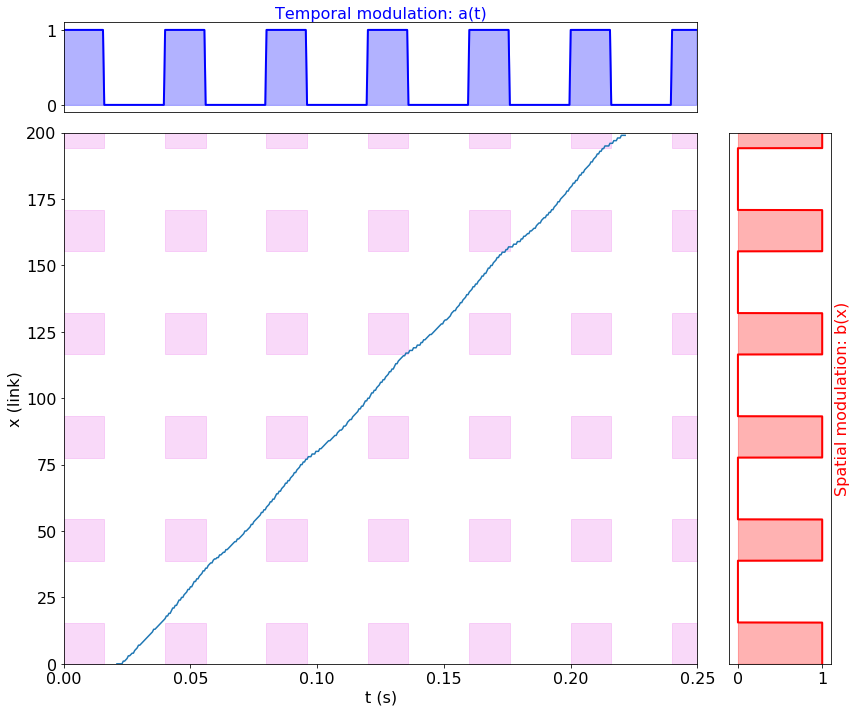

In [12]:
# estimate position from chain activity and overlay atop correction zones
t_wdw = .002
x_est = np.nan * np.zeros(len(t))
for ct, t_ in enumerate(t):
    t_mask = (t_ - t_wdw/2 <= t) & (t < t_ + t_wdw/2)
    spks_wdw = rsp.spks[t_mask, :]
    spk_c = spks_wdw.nonzero()[1]
    
    if len(spk_c) > 3:
        x_est[ct] = np.median(ntwk.x[spk_c])
    
axs = plot_czone(ctl_prm)
axs[2].plot(t, x_est)